In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision.transforms as T
from torchvision import datasets, models
from torch.utils.data import DataLoader

c:\Users\BM MONEY\miniconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
features_vector = []

# Data Augmentation
transform_pipeline = T.Compose([
    T.Resize((244, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.RandomAffine(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
model = models.efficientnet_b4(pretrained=True)

c:\Users\BM MONEY\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\BM MONEY\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Layer Freeze
for p in model.parameters():
    p.requires_grad = False
    
model.fc = torch.nn.Identity()

model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [8]:
import os

base_folder = os.path.join("..", "Merged Files")

In [9]:
# Data Preparing
for img_name in os.listdir(base_folder):
    img_path = os.path.join(base_folder, img_name)
    
    image = Image.open(img_path).convert("RGB")
    image = transform_pipeline(image).unsqueeze(0).to(device)
    
    with torch.inference_mode():
        feature = model(image)
        feature = feature.view(-1).cpu().numpy()
        
    features_vector.append(feature)

In [10]:
features_array = np.array(features_vector)
features_array

array([[-0.5383243 , -1.1565136 , -0.48161817, ..., -1.2869767 ,
        -1.4309723 , -0.8120376 ],
       [-1.2818228 ,  0.04131472, -1.4267628 , ..., -1.164061  ,
        -1.0209312 ,  0.00690764],
       [-1.4976661 , -0.9664711 , -1.3145952 , ..., -0.8416835 ,
         0.12892747, -0.26601094],
       ...,
       [ 0.218104  , -0.50168395, -0.87136966, ..., -1.6125574 ,
        -2.3262887 , -2.5280797 ],
       [-0.49222946, -0.43368962, -1.5770411 , ..., -1.1699469 ,
        -0.58146197, -1.0461011 ],
       [-1.3216293 , -1.9411415 , -2.7571402 , ..., -0.81290907,
         0.5245272 , -1.6868429 ]], dtype=float32)

In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

c:\Users\BM MONEY\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\BM MONEY\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\BM MONEY\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\BM MONEY\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

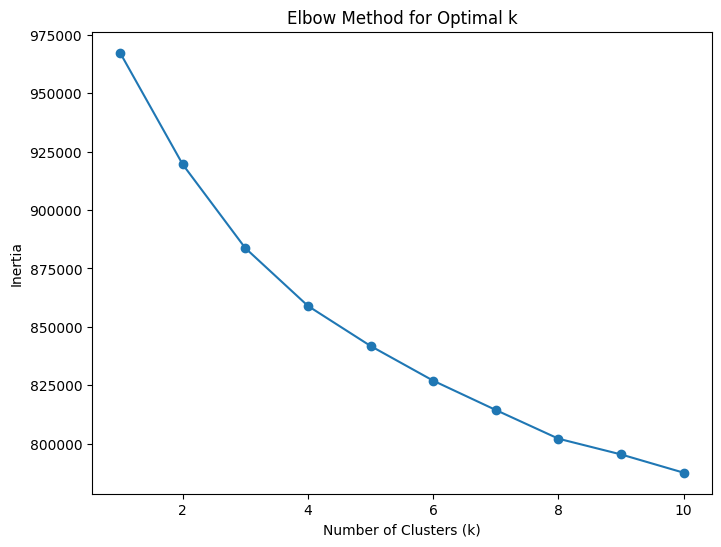

In [72]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_array)
    inertia.append(kmeans.inertia_)

# วาดกราฟ Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [12]:
kmeans = KMeans(n_clusters=3, random_state=42)

In [15]:
import umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
up1 = reducer.fit_transform(features_array)
kmeans.fit(up1)

kl = kmeans.labels_
silhouette_score(up1, kl)

c:\Users\BM MONEY\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\BM MONEY\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.4040165

In [16]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(
    n_components=3,
    covariance_type='full',
    random_state=42
)
gmm_labels = gmm.fit_predict(up1)
silhouette_score(up1, gmm_labels)

0.39363763

In [74]:
# num_clusters = 2

# for i in range(num_clusters):
#     print(f"Cluster {i+1}:")
#     cluster_images = [img_name for img_name, label in zip(os.listdir(base_folder), labels) if label == i]
#     print(cluster_images)

# # แสดงตัวอย่างภาพในแต่ละกลุ่ม
# fig, axs = plt.subplots(num_clusters, 1, figsize=(10, 5))
# for i in range(num_clusters):
#     cluster_images = [img_name for img_name, label in zip(os.listdir(base_folder), labels) if label == i]
#     axs[i].imshow(np.array(Image.open(os.path.join(base_folder, cluster_images[0]))))  # แสดงตัวอย่างภาพแรกในแต่ละกลุ่ม
#     axs[i].set_title(f"Cluster {i+1}")
#     axs[i].axis("off")

# plt.tight_layout()
# plt.show()

In [75]:
labels = kmeans.labels_

pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

sil_score = silhouette_score(features_pca, labels)
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.20829162001609802


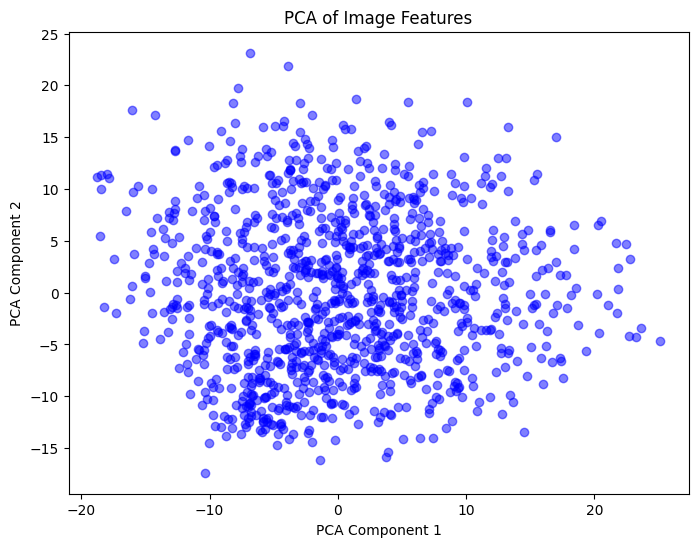

In [76]:
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c='blue', marker='o', alpha=0.5)
plt.title("PCA of Image Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

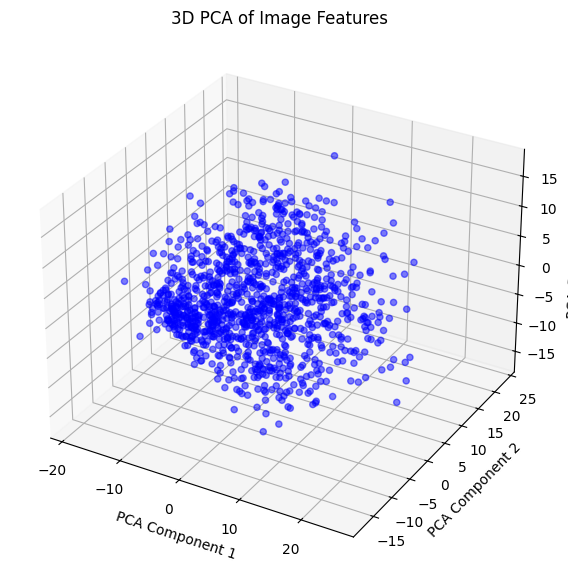

In [77]:
n_components = 3
pca = PCA(n_components=n_components)
features_pca = pca.fit_transform(features_array)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c='blue', marker='o', alpha=0.5)
ax.set_title("3D PCA of Image Features")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
plt.show()

c:\Users\BM MONEY\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


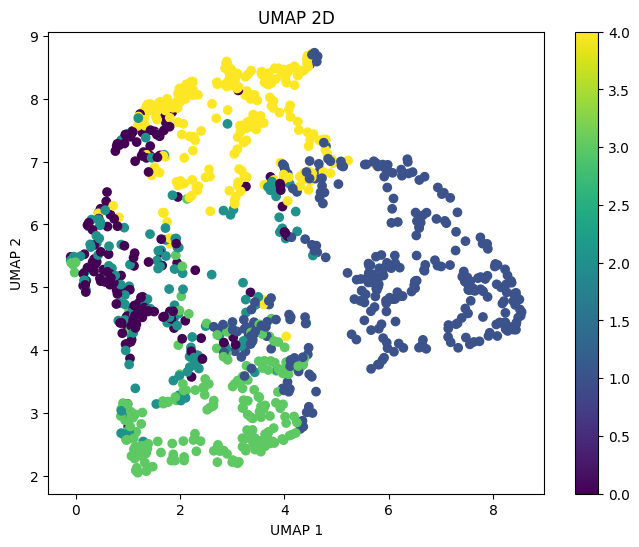

In [94]:
import umap

# ลดมิติด้วย UMAP
umap_model = umap.UMAP(n_components=300, random_state=42)
features_umap_2d = umap_model.fit_transform(features_pca)

# Plot 2D UMAP
plt.figure(figsize=(8, 6))
plt.scatter(features_umap_2d[:, 0], features_umap_2d[:, 1], c=labels, cmap='viridis')
plt.title('UMAP 2D')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()

c:\Users\BM MONEY\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


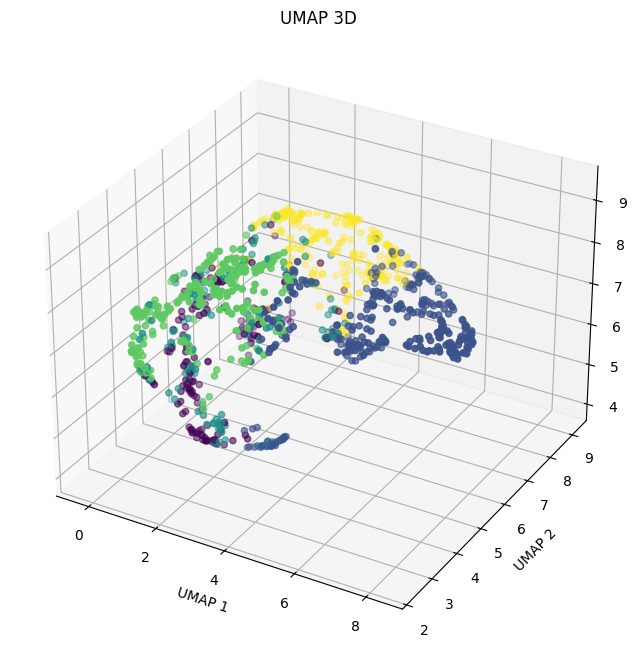

In [80]:
# สำหรับ 3D Plot
umap_model_3d = umap.UMAP(n_components=150, random_state=42)
features_umap_3d = umap_model_3d.fit_transform(features_pca)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_umap_3d[:, 0], features_umap_3d[:, 1], features_umap_3d[:, 2], c=labels, cmap='viridis')
ax.set_title('UMAP 3D')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
plt.show()

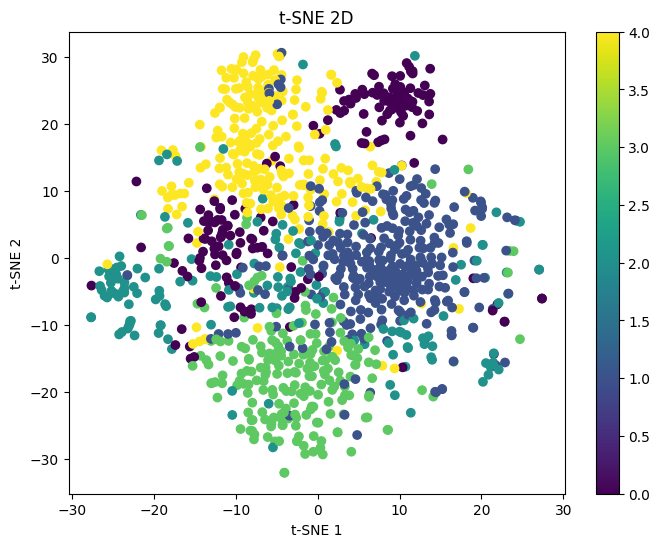

In [82]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_tsne_2d = tsne.fit_transform(features_array)

# Plot 2D t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(features_tsne_2d[:, 0], features_tsne_2d[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE 2D')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar()
plt.show()

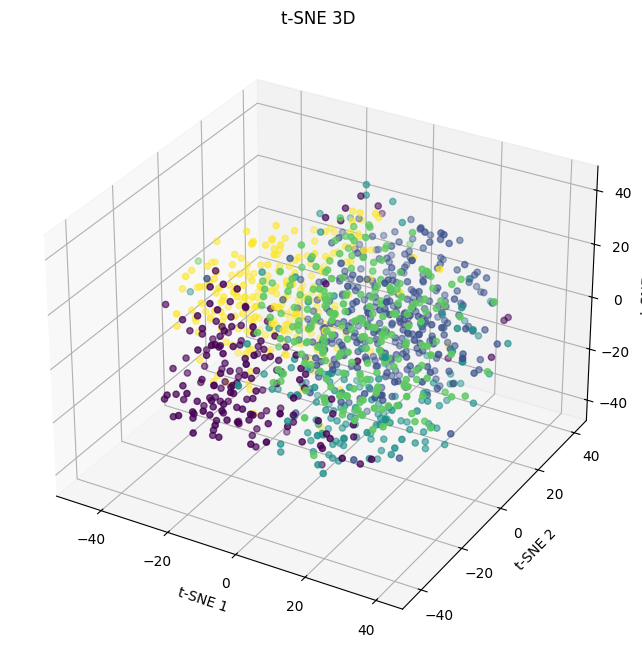

In [83]:
# สำหรับ 3D Plot
tsne_3d = TSNE(n_components=3, random_state=42)
features_tsne_3d = tsne_3d.fit_transform(features_array)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_tsne_3d[:, 0], features_tsne_3d[:, 1], features_tsne_3d[:, 2], c=labels, cmap='viridis')
ax.set_title('t-SNE 3D')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.show()

In [84]:
from sklearn.cluster import SpectralClustering
# ใช้ Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral_clustering.fit_predict(features_array)

# วัดประสิทธิภาพด้วย Silhouette Score
sil_score_spectral = silhouette_score(features_array, spectral_labels)
print(f"Spectral Clustering Silhouette Score: {sil_score_spectral}")

Spectral Clustering Silhouette Score: 0.037159647792577744


In [87]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=42)  # กำหนดจำนวนคลัสเตอร์
gmm_labels = gmm.fit_predict(features_array)

# วัดประสิทธิภาพด้วย Silhouette Score
sil_score_gmm = silhouette_score(features_array, gmm_labels)
print(f"GMM Silhouette Score: {sil_score_gmm}")

GMM Silhouette Score: 0.04815514758229256
